In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame
import os
import sys


# DDQN model
import random
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque

import matplotlib.pyplot as plt

In [2]:
script_dir = os.path.join(os.getcwd(), 'space_ship_game_RL')
if script_dir not in sys.path:
    sys.path.append(script_dir)

from setting import WIDTH, HEIGHT
from game import Game

## Environment

In [3]:
class SpaceShipEnv(gym.Env):
    """
    Gymnasium version of the SpaceShip environment.
    """
    metadata = {"render_modes": ["human"], "render_fps": 60}

    def __init__(self, frame_stack: int = 4, render_mode: str = None):
        super().__init__()
        self.frame_stack = frame_stack
        self.render_mode = render_mode

        # 建立遊戲實例
        self.game = Game(frame_stack=frame_stack)

        # 動作空間
        self.action_space = spaces.Discrete(4)

        # 觀測空間 shape=(H, W, 3*frame_stack)
        sample = self.game.stacked_state  # shape=(W, H, C)
        h, w, c = np.transpose(sample, (1,0,2)).shape
        self.observation_space = spaces.Box(
            low=0, high=255,
            shape=(h, w, c),
            dtype=np.uint8
        )

        # 延遲初始化 Pygame 視窗
        self.window = None
        self.clock = pygame.time.Clock()

    def reset(self, *, seed=None, options=None):
        # Gymnasium 正確的 reset signature
        super().reset(seed=seed)
        # 重建遊戲，清空 deque
        self.game = Game(frame_stack=self.frame_stack)

        obs = np.transpose(self.game.stacked_state, (1,0,2))
        info = {}
        return obs, info

    # 在 spaceship_env 或 spaceship_env_gymnasium 裡的 step()
    def step(self, action):
        # 1) 先記錄前一刻的關鍵數值
        prev_score  = self.game.score
        prev_health = self.game.player.sprite.health
        prev_gun     = self.game.player.sprite.gun

        # 2) 執行動作與遊戲邏輯
        self.game.update(action)

        # 3) 蒐集當前數值
        cur_score  = self.game.score
        cur_health = self.game.player.sprite.health
        cur_gun     = self.game.player.sprite.gun

        # 4) 基本打中隕石的分數增量
        reward  = float(cur_score - prev_score)

        # 5) 存活時間獎勵：每步 +0.1
        reward += 0.1

        # 6) 被石頭打到的懲罰：依受傷量負向獎勵
        damage = prev_health - cur_health
        if damage > 0:
            # 例如：每 1 點血量扣 0.5 分
            reward -= 1 * damage

        # 7) 吃到回血道具的獎勵：依回血量正向獎勵
        heal = cur_health - prev_health
        if heal > 0:
            # 例如：每回血 1 點 +0.2 分
            reward += 2 * heal

        # 9) 判斷是否結束
        terminated = (not self.game.running) or (cur_score >= 10000)
        truncated  = False
        info       = {}

        # 10) 回傳 obs, reward, done
        obs = np.transpose(self.game.stacked_state, (1,0,2))
        return obs, reward, terminated, truncated, info


    def render(self):
        if self.render_mode != "human":
            return

        if self.window is None:
            pygame.init()
            self.window = pygame.display.set_mode((WIDTH, HEIGHT))
            pygame.display.set_caption("SpaceShip RL (Gymnasium)")
        # 繪製當前一幀
        self.game.draw(self.window)
        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])

    def close(self):
        if self.window:
            pygame.quit()
            self.window = None

## DQN model

In [4]:
# 影像前處理
def preprocess_stack(raw: np.ndarray, frame_stack: int) -> torch.Tensor:
    """
    raw: np.ndarray, shape=(W, H, 3*frame_stack), dtype=uint8
    return: torch.Tensor, shape=(frame_stack, H, W), float32 in [0,1]
    """
    W, H, Ctot = raw.shape
    C = Ctot // frame_stack
    # 重塑並轉軸： (W, H, stack, C) → (stack, H, W, C)
    frames = raw.reshape(W, H, frame_stack, C).transpose(2, 1, 0, 3)
    # 轉灰階 + resize
    gray_resized = []
    for f in frames:
        # 1. RGB→灰階
        g = cv2.cvtColor(f, cv2.COLOR_RGB2GRAY)
        # 2. Resize 到 84×84
        g84 = cv2.resize(g, (84, 84), interpolation=cv2.INTER_AREA)
        gray_resized.append(g84)

    stack = np.stack(gray_resized, axis=0)          # (stack, 84, 84)
    tensor = torch.from_numpy(stack).float() / 255.0
    return tensor

In [5]:
# DQN 網路結構 (灰階單通道)
class DQN(nn.Module):
    def __init__(self, action_dim, frame_stack):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(frame_stack, 32, kernel_size=8, stride=4),  # 現在有 4 幀
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.net(x)

In [6]:
# 經驗回放
class ReplayBuffer:
    def __init__(self, capacity: int = 10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s_, d):
        self.buffer.append((s, a, r, s_, d))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_, d = map(np.array, zip(*batch))
        return (torch.FloatTensor(s),
                torch.LongTensor(a),
                torch.FloatTensor(r),
                torch.FloatTensor(s_),
                torch.FloatTensor(d))

    def __len__(self):
        return len(self.buffer)

In [7]:

class PrioritizedReplayBuffer:
    def __init__(self, capacity: int = 10000, alpha: float = 0.6):
        """
        capacity: 最大儲存筆數
        alpha: priority 調整強度（0 = 均勻抽樣, 1 = 完全按 priority）
        """
        self.capacity   = capacity
        self.buffer     = []                                   # list of (s,a,r,s_,done)
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.pos        = 0
        self.alpha      = alpha

    def push(self, s, a, r, s_, d):
        """加入一筆新的 transition，priority 給當前最大值保證先被抽到"""
        max_prio = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append((s, a, r, s_, d))
        else:
            self.buffer[self.pos] = (s, a, r, s_, d)
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size: int, beta: float = 0.4):
        """
        按 priority 抽樣
        beta: importance-sampling 校正強度 (0 = 無校正, 1 = 完全校正)
        回傳 (s, a, r, s_, d, weights, indices)
        """
        # 取出有效的 priorities
        prios = self.priorities if len(self.buffer) == self.capacity else self.priorities[:len(self.buffer)]
        # 計算抽樣機率
        probs = prios ** self.alpha
        probs /= probs.sum()
        # 按概率抽 batch
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        # importance-sampling weights
        total   = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        # 拆包
        s, a, r, s_, d = zip(*samples)
        return (
            torch.FloatTensor(s),
            torch.LongTensor(a),
            torch.FloatTensor(r),
            torch.FloatTensor(s_),
            torch.FloatTensor(d),
            torch.FloatTensor(weights),
            indices
        )

    def update_priorities(self, indices, losses, offset: float = 1e-6):
        """
        用新的 TD-error (losses) 更新相應 indices 的 priorities
        offset 避免 priority 變 0
        """
        for idx, loss in zip(indices, losses):
            self.priorities[idx] = abs(loss.item()) + offset

    def __len__(self):
        return len(self.buffer)

In [8]:
import numpy as np
import torch
import random
from gymnasium.vector import AsyncVectorEnv

In [9]:
# --- 超參數 ---
NUM_ENVS     = 8
EPISODES     = 500     # 每個 env 跑 500 episodes
TOTAL_EPISODES = EPISODES * NUM_ENVS
BATCH_SIZE   = 512     # 增大 batch size
GAMMA        = 0.99
EPS_START    = 1.0
EPS_END      = 0.01
EPS_DECAY    = 0.995   # 緩和指數衰減
TARGET_UPDATE = 10

In [10]:
# --- 建立多 Env ---
def make_env():
    return lambda: SpaceShipEnv(frame_stack=4, render_mode=None)

envs = AsyncVectorEnv([make_env() for _ in range(NUM_ENVS)])
obs, infos = envs.reset()              # obs.shape = (NUM_ENVS, H, W, C)

In [11]:
# --- Episode 計數與記錄 ---
episode_rewards = np.zeros(NUM_ENVS)
episode_count   = 0
best_reward     = -float("inf")
reward_history  = []
epsilon         = EPS_START
last_reward     = 0.0   # <— 新增


In [12]:
# --- 初始化 Network / Optimizer / Buffer ---
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net  = DQN(envs.single_action_space.n, 4).to(device)
target_net  = DQN(envs.single_action_space.n, 4).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer   = torch.optim.Adam(policy_net.parameters(), lr=1e-4)

buffer      = PrioritizedReplayBuffer(capacity=100000, alpha=0.6)

In [ ]:
# --- 主訓練迴圈 ---
while episode_count < TOTAL_EPISODES:
    # 1) ε-greedy 選動作
    actions = []
    for i in range(NUM_ENVS):
        if random.random() < epsilon:
            actions.append(envs.single_action_space.sample())
        else:
            s = preprocess_stack(obs[i], 4).unsqueeze(0).to(device)
            with torch.no_grad():
                actions.append(policy_net(s).argmax(1).item())

    # 2) 並行 step
    next_obs, rewards, terminateds, truncateds, infos = envs.step(actions)
    dones = np.logical_or(terminateds, truncateds)

    # 3) 存入 Buffer、累加 episode reward
    for i in range(NUM_ENVS):
        s_np      = preprocess_stack(obs[i], 4).cpu().numpy()
        s1_np     = preprocess_stack(next_obs[i], 4).cpu().numpy()
        buffer.push(s_np, actions[i], float(rewards[i]), s1_np, bool(dones[i]))
        episode_rewards[i] += rewards[i]

    obs = next_obs

    # 4) DDQN 更新（與單 env 相同，只是 batch 來自多 env）
    if len(buffer.buffer) >= BATCH_SIZE:
        s, a, r, s_, d, weights, indices = buffer.sample(BATCH_SIZE, beta=0.4)
        s   = s.to(device);    a   = a.unsqueeze(1).to(device)
        r   = r.unsqueeze(1).to(device)
        s_  = s_.to(device);   d   = d.unsqueeze(1).to(device)
        weights = weights.unsqueeze(1).to(device)

        q_pred = policy_net(s).gather(1, a)
        with torch.no_grad():
            best_next = policy_net(s_).argmax(1, keepdim=True)
            q_next     = target_net(s_).gather(1, best_next)
            q_target   = r + GAMMA * q_next * (1 - d)

        losses = torch.nn.functional.mse_loss(q_pred, q_target, reduction='none')
        loss   = (losses * weights).mean()
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        buffer.update_priorities(indices, losses.detach().squeeze())

    # 5) 處理結束的 env
    if dones.any():
        done_idxs = np.where(dones)[0]
        for idx in done_idxs:
            rew = episode_rewards[idx]
            reward_history.append(rew)

            # 更新 best reward
            if rew > best_reward:
                best_reward = rew
                torch.save(policy_net.state_dict(), "best_ddqn_space_ship.pth")

            # 衰減 ε（每集一次）
            epsilon = max(EPS_END, epsilon * EPS_DECAY)

            # 集數 +1，並印出這一集的結果
            episode_count += 1
            print(f"Episode {episode_count:4d} | "
                  f"Latest Reward: {rew:7.1f} | Best: {best_reward:7.1f} | "
                  f"Epsilon: {epsilon:.3f}")

            # 重置該 env 的累計
            episode_rewards[idx] = 0

        # 只重置結束的那些 env
        resets = envs.env_method("reset", indices=done_idxs)
        for j, idx in enumerate(done_idxs):
            obs[idx] = resets[j][0]

    # 6) 同步 target network
    if episode_count % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

In [ ]:
# 超參數
EPISODES       = 500
BATCH_SIZE     = 256
GAMMA          = 0.99
EPS_START      = 1.0
EPS_END        = 0.01
EPS_DECAY      = 0.990
LR             = 1e-4
TARGET_UPDATE  = 5
FRAME_STACK    = 4

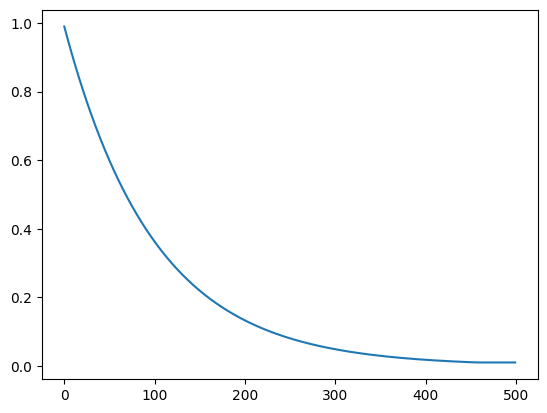

In [ ]:
epsilon_list=[]
epsilon=EPS_START
for i in range(500):
    epsilon = max(EPS_END, epsilon * EPS_DECAY)
    epsilon_list.append(epsilon)
plt.plot(epsilon_list)

In [ ]:
# 初始化
env = SpaceShipEnv(frame_stack=FRAME_STACK, render_mode=None)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

action_dim = env.action_space.n
policy_net = DQN(action_dim, FRAME_STACK).to(device)
target_net = DQN(action_dim, FRAME_STACK).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
buffer = ReplayBuffer(capacity=10000)


In [ ]:
# 主訓練迴圈
epsilon = EPS_START
reward_history = []
best_reward = -float("inf")

for episode in range(1, EPISODES+1):
    # reset → obs, info
    raw, _ = env.reset()
    state = preprocess_stack(raw, FRAME_STACK).to(device)
    total_reward = 0.0
    done = False

    while not done:
        # ε-greedy 取動作
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_vals = policy_net(state.unsqueeze(0))
                action = q_vals.argmax(1).item()

        # step → obs, reward, terminated, truncated, info
        raw_next, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        next_state = preprocess_stack(raw_next, FRAME_STACK).to(device)
        total_reward += reward

        # 存入回放記憶
        buffer.push(state.cpu().numpy(),
                    action,
                    reward,
                    next_state.cpu().numpy(),
                    done)
        state = next_state

        # 4) 更新 policy_net
        if len(buffer) >= BATCH_SIZE:
            s, a, r, s_, d = buffer.sample(BATCH_SIZE)
            s  = s.to(device)
            a  = a.unsqueeze(1).to(device)
            r  = r.unsqueeze(1).to(device)
            s_ = s_.to(device)
            d  = d.unsqueeze(1).to(device)

            # 預測 Q(s,a)
            q_pred = policy_net(s).gather(1, a)
            # 計算 target Q
            with torch.no_grad():
                # 1) 用 policy_net 找到下一步最優動作 index
                best_next_actions = policy_net(s_).argmax(dim=1, keepdim=True)
                # 2) 用 target_net 評估這些動作的 Q 值
                q_next = target_net(s_).gather(1, best_next_actions)
                # 3) 組成 DDQN target
                q_target = r + GAMMA * q_next * (1 - d)

            loss = F.mse_loss(q_pred, q_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # 5) 更新 target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # 6) 紀錄 & 儲存最佳模型
    reward_history.append(total_reward)
    if total_reward > best_reward:
        best_reward = total_reward
        torch.save(policy_net.state_dict(), "best_dqn_space_ship.pth")

    # 7) 調整 ε
    epsilon = max(EPS_END, epsilon * EPS_DECAY)

    # 8) 每 5 集回報一次
    if episode % 5 == 0:
        print(f"Episode {episode:3d} | Reward: {total_reward:7.1f} | "
                f"Best: {best_reward:7.1f} | Epsilon: {epsilon:.3f}")

env.close()

KeyboardInterrupt: 

# Multiple Environment

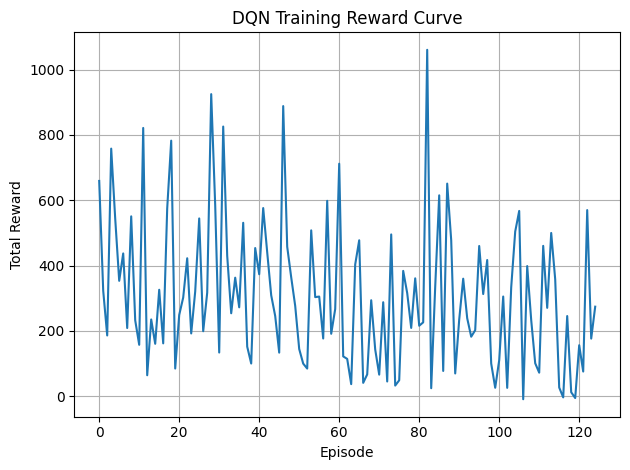

In [ ]:
# 畫出 reward 曲線圖
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Reward Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

## Play with Train model

In [ ]:
def play_with_trained_model():
    env = SpaceShipEnv()
    policy_net = DQN(action_dim)
    policy_net.load_state_dict(torch.load("best_dqn_space_ship.pth", map_location=torch.device('cuda')))
    policy_net.eval()

    state = preprocess(env.reset())
    done = False
    reward = 0

    while not done:
        env.render()
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = policy_net(state_tensor)
            action = torch.argmax(q_values).item()

        next_state_raw, reward, done, _ = env.step(action)
        state = preprocess(next_state_raw)

    env.close()
    print(f"reward: {reward}")


In [ ]:
def record_episode_as_video(env, video_path="gameplay.mp4"):
    frames = []

    state = env.reset()
    done = False

    while not done:
        env.render()
        action = random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        
        # 把畫面抓下來（RGB）
        surface = pygame.display.get_surface()
        frame = pygame.surfarray.array3d(surface)  # shape: (W, H, 3)
        frame = np.transpose(frame, (1, 0, 2))     # pygame 是 x,y → imageio 是 y,x
        frames.append(frame)


    # 儲存成影片
    imageio.mimsave(video_path, frames, fps=60, quality=9)
    print(f"Saved gameplay video to: {video_path}")


In [ ]:
# env = SpaceShipEnv()
# record_episode_as_video(env, "space_ship_run.mp4")
# env.close()

In [ ]:
# 呼叫測試函數
# play_with_trained_model()